## Identify Fraud from Enron Email
#### Project Overview
In this project, you will play detective, and put your machine learning skills to use by building an algorithm to identify Enron Employees who may have committed fraud based on the public Enron financial and email dataset.

#### Project Introduction
In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement, or plea deal with the government, or testified in exchange for prosecution immunity.



In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
from time import time

import numpy as np
import pandas as pd
import pickle

import matplotlib as pl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import fill_between
sns.set_style("white")


In [3]:
dataPath = '/Users/omojumiller/mycode/MachineLearningNanoDegree/IntroToMachineLearning/'
sys.path.append(dataPath+'tools/')
sys.path.append(dataPath+'final_project/')

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
from helper_files import compareTwoFeatures, computeFraction, findPersonBasedOnTwoFeatures 
from helper_files import validateClf, printClassifierOutputTable, printDataTableAtThreshold

# Optimize Feature Selection/Engineering
## Task 1: Feature selection

The dataset used in this project is stored in a Python dictionary created by combining the Enron email and financial data, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']

email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

POI label: [‘poi’]

You can take a look at this [enron61702insiderpay.pdf](enron61702insiderpay.pdf) file to get a feel of the data yourself.


In [27]:
### Load the dictionary containing the dataset
### The data that I am loading in here is the one that has be cleansed of outliers. 
### For more information on that, refer to the notebook titled "cleanDataForOutliers" in the same folder.

with open(dataPath+'final_project/final_project_dataset.pkl', "r") as data_file:
    data_dict = pickle.load(data_file)
    
    

In [28]:
#Stylistic Options for plots
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  

for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)

## Data Exploration

- Lets find the following facts about our dataset
    - Total number of data points
    - Allocation across classes (POI/non-POI)
    - Number of features used
    - Are there features with many missing values? etc.

In [29]:
from __future__ import division


In [30]:
allFeatures = ['poi', 
'bonus','deferral_payments',
'deferred_income', 'director_fees','exercised_stock_options','expenses',
'from_messages','from_poi_to_this_person','from_this_person_to_poi',
'loan_advances','long_term_incentive','other','restricted_stock','restricted_stock_deferred', 'salary',
'shared_receipt_with_poi','to_messages','total_payments','total_stock_value']

# 'email_address' I took out this feature because it could not be converted to an int or float

mydata = featureFormat(data_dict, allFeatures, remove_NaN=False, remove_all_zeroes=False, remove_any_zeroes=False)

In [31]:
df = pd.DataFrame(mydata)
df.columns = allFeatures

df.head()

,poi,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,0,600000,NaN,NaN,NaN,NaN,94299,29,38,1,NaN,NaN,1740,585062,NaN,365788,702,807,1061827,585062
1,0,1200000,1295738,-1386055,NaN,6680544,11200,NaN,NaN,NaN,NaN,1586055,2660303,3942714,NaN,267102,NaN,NaN,5634343,10623258
2,0,350000,NaN,-400729,NaN,4890344,78552,NaN,NaN,NaN,NaN,NaN,12961,1788391,NaN,170941,NaN,NaN,211725,6678735
3,0,NaN,NaN,NaN,NaN,651850,NaN,12,10,0,NaN,NaN,NaN,386335,NaN,NaN,58,764,NaN,1038185
4,1,1500000,NaN,-3117011,NaN,5538001,34039,32,32,21,NaN,1617011,11350,853064,NaN,243293,1035,1045,288682,6391065


In [32]:
n_datapoints = len(df)
n_features = len(df.columns) - 1
n_poi = len(df.query('poi == 1'))
n_npoi = len(df.query('poi == 0'))


print "%s: %d" % ("Total number of data points", len(df))
print "%s: %d" % ('Total number of POI', n_poi)
print "%s: %d" % ('Total number of Non POI', n_npoi)
print "%s: %d" % ("Number of features used", n_features + 1) #for the email address feature
print "%s: %s" % ("Are there features with many missing values?", "yes")

Total number of data points: 146
Total number of POI: 18
Total number of Non POI: 128
Number of features used: 20
Are there features with many missing values?: yes


In [33]:
plt.rcParams["axes.labelsize"] = 16.
plt.rcParams["xtick.labelsize"] = 14.
plt.rcParams["ytick.labelsize"] = 14.
plt.rcParams["legend.fontsize"] = 11.
plt.rcParams["axes.titlesize"] = 1.25 * plt.rcParams['font.size']
plt.rcParams['figure.figsize'] = (8, 6)


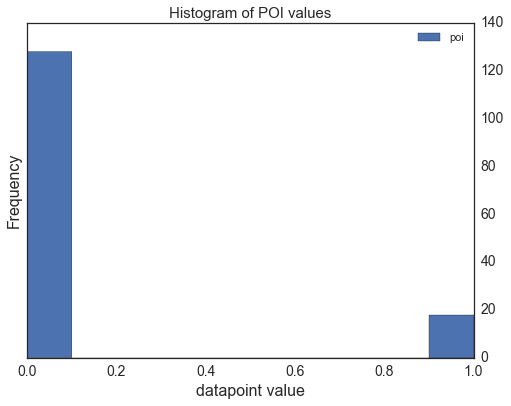

In [34]:
p = df['poi'].plot(kind = 'hist', rot = 0)
_ = p.set_xlabel('datapoint value'), p.set_ylabel("Frequency"), p.legend(["poi"])
_ = p.yaxis.tick_right()
_ = p.set_title('Histogram of POI values')

poi                           0.0000
bonus                         0.4384
deferral_payments             0.7329
deferred_income               0.6644
director_fees                 0.8836
exercised_stock_options       0.3014
expenses                      0.3493
from_messages                 0.4110
from_poi_to_this_person       0.4110
from_this_person_to_poi       0.4110
loan_advances                 0.9726
long_term_incentive           0.5479
other                         0.3630
restricted_stock              0.2466
restricted_stock_deferred     0.8767
salary                        0.3493
shared_receipt_with_poi       0.4110
to_messages                   0.4110
total_payments                0.1438
total_stock_value             0.1370


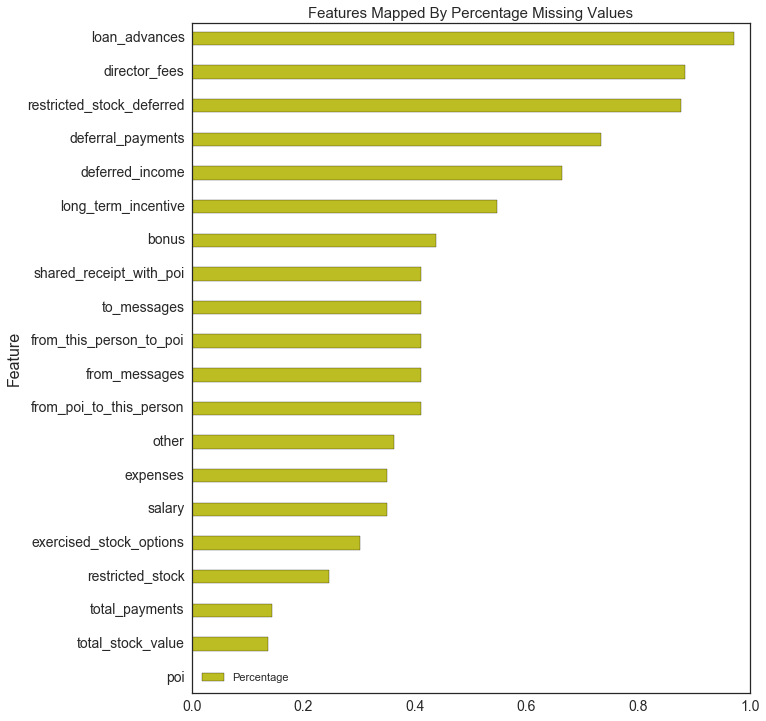

In [35]:
# Find features that have any missing values and list their percentages
count_nan = (len(df) - df.count()) / len(df)
percentage_nan = {}

for item in range (0, len(count_nan)):
    print "{:30}{:4.4f}".format(count_nan.index[item], count_nan[item])
    percentage_nan[count_nan.index[item]] = count_nan[item]
    

w = 0.4


plt.rcParams['figure.figsize'] = (10, 12)
percentage_nan_frame = pd.DataFrame({'Percentage': list(percentage_nan.values()),
                                     'Feature': list(percentage_nan.keys())})
percentage_nan_frame.sort_values(by = 'Percentage', inplace = True)
ax =percentage_nan_frame.plot(kind = 'barh',  width=w, x = 'Feature', color = tableau20[16], 
                              title="Features Mapped By Percentage Missing Values")

plt.rcParams['figure.figsize'] = (8, 6)

In [36]:
# deal with the missing data by setting their value to 0
df.fillna(0, inplace=True)

df.head()

,poi,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
0,0,600000,0,0,0,0,94299,29,38,1,0,0,1740,585062,0,365788,702,807,1061827,585062
1,0,1200000,1295738,-1386055,0,6680544,11200,0,0,0,0,1586055,2660303,3942714,0,267102,0,0,5634343,10623258
2,0,350000,0,-400729,0,4890344,78552,0,0,0,0,0,12961,1788391,0,170941,0,0,211725,6678735
3,0,0,0,0,0,651850,0,12,10,0,0,0,0,386335,0,0,58,764,0,1038185
4,1,1500000,0,-3117011,0,5538001,34039,32,32,21,0,1617011,11350,853064,0,243293,1035,1045,288682,6391065


## Outlier removal
If there are outliers, remove outliers

This is an iteratable process. I need to do this for each combination of features I want to use


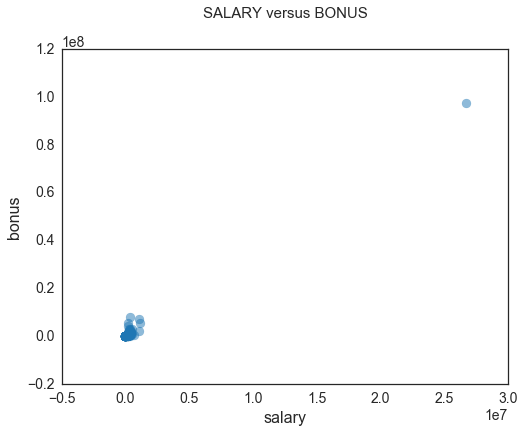

Clean data for outliers


In [37]:
compareTwoFeatures('salary', 'bonus', df)
print "Clean data for outliers"

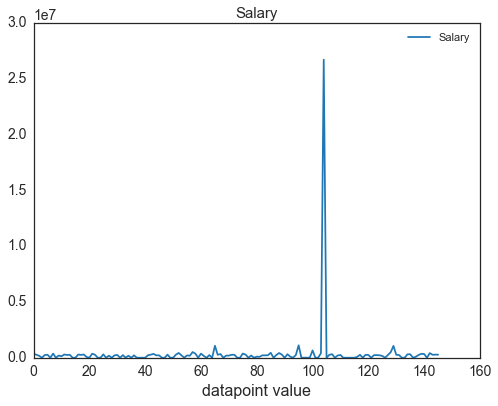

In [38]:
ax = plt.plot(df['salary'], label='Salary', color=tableau20[0])

_= plt.xlabel('datapoint value')
_= plt.title('Salary')

_= plt.legend()
plt.show()

In [39]:
df.loc[df['salary'] > 0.8 * 1e7] # This is where the outlier is, what I have to do now is find out who it is


,poi,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,from_messages,from_poi_to_this_person,from_this_person_to_poi,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,shared_receipt_with_poi,to_messages,total_payments,total_stock_value
104,0,97343619,32083396,-27992891,1398517,311764000,5235198,0,0,0,83925000,48521928,42667589,130322299,-7576788,26704229,0,0,309886585,434509511


In [40]:

data = featureFormat(data_dict, ['bonus', 'salary'], remove_any_zeroes=True)
np.where(data > 0.8 * 1e8) # This is where the outlier is, what I have to do now is find out who i

(array([57]), array([0]))

In [41]:
for key, value in data_dict.iteritems():
    if (value['bonus'] >= int(data[57][1]) and 
        value['bonus'] != "NaN" and
        value['salary'] != "NaN"):
        print "{:20}{:12}${:<12,.2f}{:12}${:<12,.2f}".format(key, 'salary is ', value['salary'],
                                                   ' bonus ', value['bonus'])

TOTAL               salary is   $26,704,229.00 bonus      $97,343,619.00


In [17]:

df = df.drop(104)
df = df.reset_index(drop=True)

In [19]:
# Remove the source of the outlier

data_dict.pop( 'TOTAL')
#data_dict.pop( 'BHATNAGAR SANJAY')

print "Deleted following records with keys:"
print 'TOTAL'
#print 'BHATNAGAR SANJAY'

# We can now go back and rerun the regression to see what the data really looks like.

Deleted following records with keys:
TOTAL


In [18]:
df.loc[104]

poi                                0
bonus                              0
deferral_payments                  0
deferred_income                    0
director_fees                      0
exercised_stock_options      1324578
expenses                           0
from_messages                     36
from_poi_to_this_person            0
from_this_person_to_poi            0
loan_advances                      0
long_term_incentive                0
other                              0
restricted_stock              560170
restricted_stock_deferred          0
salary                             0
shared_receipt_with_poi           10
to_messages                      517
total_payments                     0
total_stock_value            1884748
Name: 104, dtype: float64

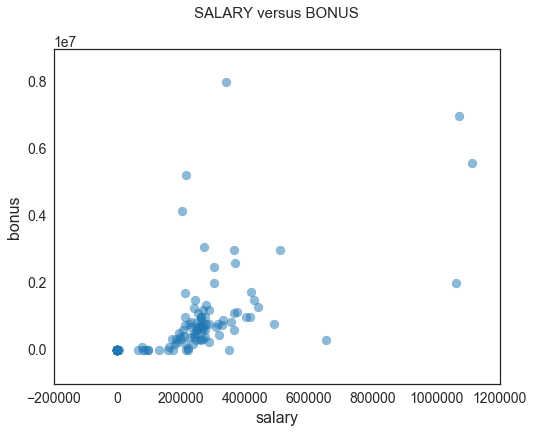

In [20]:
compareTwoFeatures('salary', 'bonus', df)

## Task: Data exploration
- Get descriptive statistics



In [ ]:
x = range(0,len(df))

pltSalary = df['salary']

ax = plt.plot(pltSalary, label='Salary', color=tableau20[0])
fill_between(x, pltSalary, 0, alpha=0.5, color=tableau20[19])

_= plt.xlabel('datapoint value')
_= plt.title('Salary')

#_= plt.legend(loc='upper center', shadow=True, fontsize='medium')
_= plt.legend()
plt.xlim(0, 94)
plt.show()

df['salary'].describe()


In [ ]:
x = range(0,len(df))

plt.plot(x, df['exercised_stock_options'], label='Exercised Stock Options', color=tableau20[8])
fill_between(x, df['exercised_stock_options'], 0, alpha=0.5, color=tableau20[19])

_= plt.xlabel('datapoint value')
_= plt.title('Exercised Stocks')

_= plt.legend()
plt.xlim(0, 100)
plt.show()

df['exercised_stock_options'].describe()

In [ ]:
x = range(0,len(df))

plt.plot(x, df['restricted_stock'], label='Restricted Stock', color=tableau20[0])
fill_between(x, df['restricted_stock'], 0, alpha=0.5, color=tableau20[4])

_= plt.xlabel('datapoint value')
_= plt.title('Restricted Stock')

_= plt.legend()

plt.xlim(0, 108)
plt.show()

df['restricted_stock'].describe()

In [ ]:
x = range(0,len(df))

plt.plot(x, df['bonus'], label='Bonus', color=tableau20[0])
fill_between(x, df['bonus'], 0, alpha=0.5, color=tableau20[4])

_= plt.xlabel('datapoint value')
_= plt.title('Bonus')
plt.xlim(0, 81)
_= plt.legend()

df['bonus'].describe()

In [ ]:
f1, f2 = 'salary','exercised_stock_options'
data = compareTwoFeatures(f1, f2, df)


In [ ]:
prtLaTex = 0
threshold = 8000000
printDataTableAtThreshold(f1, f2, data_dict, threshold, prtLaTex)

In [ ]:
f1, f2 = 'salary','restricted_stock'
data = compareTwoFeatures(f1, f2, df)



In [ ]:
threshold = 3000000
printDataTableAtThreshold(f1, f2, data_dict, threshold, prtLaTex)

In [ ]:
f1, f2 = 'salary','bonus'
data = compareTwoFeatures(f1, f2, df)


In [ ]:
threshold = 4000000
printDataTableAtThreshold(f1, f2, data_dict, threshold, prtLaTex)

### Engineered Feature
- #### Fraction of messages to and from POI

## Task 3: Create new feature(s)
- features_list is a list of strings, each of which is a feature name.
- The first feature must be "poi".
- Store to `my_dataset` for easy export below.

In [ ]:
submit_dict = {}
for name in data_dict:

    data_point = data_dict[name]

    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = computeFraction( from_poi_to_this_person, to_messages )
    data_point["fraction_from_poi"] = fraction_from_poi


    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = computeFraction( from_this_person_to_poi, from_messages )
    submit_dict[name]={"from_poi_to_this_person":fraction_from_poi,
                       "from_this_person_to_poi":fraction_to_poi}
    
    data_point["fraction_to_poi"] = fraction_to_poi
    


Extract features and labels from dataset

In [ ]:
feature_list = ['poi', 'bonus', 'exercised_stock_options', 'restricted_stock']
#'fraction_from_poi','fraction_to_poi',
#'from_poi_to_this_person','from_this_person_to_poi','salary']

my_dataset = data_dict

data = featureFormat(my_dataset, feature_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

print "The features we are using to train our model are as follows:"
print feature_list

## Adhoc Features

['poi', 'bonus', 'exercised_stock_options', 'restricted_stock']
 #'fraction_from_poi','fraction_to_poi',
 #'from_poi_to_this_person','from_this_person_to_poi','salary']
 
 ## XGBoost Features
['poi', 'expenses', 'other', 'deferred_income', 'from_poi_to_this_person', 'exercised_stock_options', 'salary', 'total_stock_value', 'total_payments', 'bonus', 'long_term_incentive', 'restricted_stock_deferred', 'from_messages', 'shared_receipt_with_poi', 'deferral_payments', 'to_messages']

## Random Forest Features

['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'expenses', 'other', 'total_payments', 'restricted_stock', 'deferred_income', 'shared_receipt_with_poi', 'salary']

# Pick and Tune an Algorithm
## Task 4: Try a variety of classifiers
- Please name your classifier clf for easy export below.
- Note that if you want to do PCA or other multi-stage operations, you'll need to use Pipelines. For more info: http://scikit-learn.org/stable/modules/pipeline.html

# Validate and Evaluate
## Task 5: Tune your classifier
- Achieve better than .3 precision and recall. Using our testing script. Check the `tester.py` script in the final project folder for details on the evaluation method, especially the validateClf function. Because of the small size of the dataset, the script uses `stratified shuffle split cross validation`. For more info: http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html


In [ ]:
feature_list

In [ ]:
from sklearn.cross_validation import cross_val_score 
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn.ensemble import ExtraTreesClassifier

folds = 1000


clf = ExtraTreesClassifier()
print '_'*20, clf.__class__.__name__, '_'*20
print "Training the data"


t0 = time()
results_et = validateClf(clf, my_dataset, feature_list, folds)
print("done in %0.3fs" % (time() - t0)) 

cm_et = [[results_et['true_negatives'], results_et['false_negatives']],
     [results_et['true_positives'], results_et['false_positives']]]


In [ ]:

from sklearn.ensemble import RandomForestClassifier
from time import time


clf = RandomForestClassifier()
print '_'*20, clf.__class__.__name__, '_'*20
print "Training the data"


t0 = time()
results_rf = validateClf(clf, my_dataset, feature_list, folds)
print("done in %0.3fs" % (time() - t0))

cm_rf = [[results_rf['true_negatives'], results_rf['false_negatives']],
     [results_rf['true_positives'], results_rf['false_positives']]]


In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l1')

print '_'*20, clf.__class__.__name__, '_'*20
print "Training the data"

t0 = time()
scores = cross_val_score(clf, features, labels, cv=10)
results_lr= validateClf(clf, my_dataset, feature_list, folds)
print("done in %0.3fs" % (time() - t0))

cm_lr = [[results_lr['true_negatives'], results_lr['false_negatives']],
     [results_lr['true_positives'], results_lr['false_positives']]]


In [ ]:
from xgboost import XGBClassifier as XGBC


clf = XGBC()

print '_'*20, clf.__class__.__name__, '_'*20
print "Training the data"


t0 = time()
results_xgb = validateClf(clf, my_dataset, feature_list, folds)
print("done in %0.3fs" % (time() - t0))  

cm_xgb = [[results_xgb['true_negatives'], results_xgb['false_negatives']],
     [results_xgb['true_positives'], results_xgb['false_positives']]]


In [ ]:
results = [results_et, results_lr, results_rf, results_xgb]

In [ ]:
printClassifierOutputTable(results, 0)

## Tune choosen algorithm

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit

print '_'*20, 'Tuning XGBoost', '_'*20
print "Training the data"


# max_delta_step, Maximum delta step we allow each tree's weight estimation to be. 
# If the value is set to 0, it means there is no constraint. If it is set to a positive value, 
# it can help making the update step more conservative. Usually this parameter is not needed, 
# but it might help in logistic regression when class is extremely imbalanced. 
# Set it to value of 1-10 might help control the update

cv_params = {'max_depth': [3,5,7],
             'min_child_weight': [1,3,5],
             'max_delta_step':[0, 1, 2],
             'learning_rate': [0.01, 0.1, 0.02, 0.2]}

params = {}
params['colsample_bytree'] = 1
params['objective'] = 'binary:logistic'

# Build a stratified shuffle object because of unbalanced data
folds = 1000
ssscv = StratifiedShuffleSplit(labels, folds, random_state = 42)


grid = GridSearchCV(XGBC(**params), 
                            cv_params, cv=ssscv, n_jobs = -1) 
grid.fit(features, labels)

# Optimize for precision




In [ ]:
clf =  grid.best_estimator_
print clf
results_tuning = validateClf(clf, my_dataset, feature_list, folds)

print "\n"
print '_'*20, 'Metrics of tuned '+clf.__class__.__name__, '_'*20, '\n'
print "precision : %.3f" % results_tuning['precision']
print "recall, : %.3f" % results_tuning['recall']
print "f1 : %.3f" % results_tuning['f1']


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.02, max_delta_step=1, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)


____________________ Metrics of tuned XGBClassifier ____________________ 

precision : 0.639
recall, : 0.318
f1 : 0.424


## Task 6: Export solution
Dump your classifier, dataset, and features_list so anyone can check your results. You do not need to change anything below, but make sure that the version of `poi_id.py` that you submit can be run on its own and generates the necessary .pkl files for validating your results.

In [ ]:
dump_classifier_and_data(clf, my_dataset, feature_list)